In [271]:
pip install catboost

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A. READ DATA

I. MEAL INFO

In [273]:
meal_info = pd.read_csv('/content/drive/MyDrive/Food Demand/meal_info.csv')
meal_info.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


II. FULFILLMENT CENTER INFO

In [274]:
fulfillment_center = pd.read_csv('/content/drive/MyDrive/Food Demand/fulfilment_center_info.csv')

In [275]:
fulfillment_center.head(5)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


III. TRAIN DATASET

In [276]:
df = pd.read_csv('/content/drive/MyDrive/Food Demand/train.csv')

In [277]:
df.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [278]:
df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [279]:
df.shape

(456548, 9)

IV. TEST DATA

In [280]:
test = pd.read_csv('/content/drive/MyDrive/Food Demand/test_QoiMO9B.csv')

In [281]:
test.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


## B. DERIVING NEW FEATURES

In [282]:
df['discount_percent'] = (df['base_price'] - df['checkout_price'])/df['base_price']*100
df['discount y/n'] = [1 if x>0 else 0 for x in (df['base_price']-df['checkout_price'])]

test['discount_percent'] = (test['base_price'] - test['checkout_price'])/test['base_price']*100
test['discount y/n'] = [1 if x>0 else 0 for x in (test['base_price']-test['checkout_price'])]

## B. DATA PREPROCESSING

In [283]:
df_merge = df.merge(meal_info, how='left', left_on='meal_id', right_on='meal_id')

In [284]:
df_merge_center = df_merge.merge(fulfillment_center, how='left', left_on='center_id', right_on='center_id')

In [285]:
df_merge_center.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount_percent,discount y/n,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,10.151684,1,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,-0.736214,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,0.736052,1,Beverages,Thai,647,56,TYPE_C,2.0


In [241]:
# city_encode = {590:4, 526:3, 638:2}
# df_merge_center['city_code'] = df_merge_center['city_code'].map(city_encode)
# df_merge_center['city_code'] = df_merge_center['city_code'].fillna(1)

In [286]:
columns_encoder = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
transform_list = []
for col in columns_encoder:
  result = df_merge_center.groupby(col)['num_orders'].sum().sort_values().rank()
  transform_list.append(result)
  df_merge_center[col] = df_merge_center[col].map(result)

In [287]:
df_final = df_merge_center.copy(deep=True)

In [288]:
df_final.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount_percent,discount y/n,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,9.0,50.0,136.83,152.29,0,0,177,10.151684,1,14.0,3.0,46.0,8.0,1.0,6.0
1,1466964,1,9.0,48.0,136.83,135.83,0,0,270,-0.736214,0,14.0,3.0,46.0,8.0,1.0,6.0
2,1346989,1,9.0,36.0,134.86,135.86,0,0,189,0.736052,1,14.0,3.0,46.0,8.0,1.0,6.0


In [289]:
df_final['Month'] = df_final['week'].apply(lambda x: int(x / 4)+1)
df_final['Year'] = df_final['week'].apply(lambda x: int(x / 52)+1)
df_final['Quarter'] = df_final['week'].apply(lambda x: int(x / 13)+1)

In [190]:
# def convert_month(input_month):
#   if (input_month>=1 and input_month<=12):
#     return input_month
#   elif (input_month%12==0):
#     return 12
#   else:
#     return input_month%12

# def convert_quarter(input_quarter):
#   if (input_quarter>=1 and input_quarter<=4):
#     return input_quarter
#   elif (input_quarter%4==0):
#     return 4
#   else:
#     return input_quarter%4

In [191]:
# df_final['Month'] = df_final['Month'].apply(lambda x: convert_month(x))
# df_final['Quarter'] = df_final['Quarter'].apply(lambda x: convert_quarter(x))

In [290]:
df_final.head(1)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount_percent,discount y/n,category,cuisine,city_code,region_code,center_type,op_area,Month,Year,Quarter
0,1379560,1,9.0,50.0,136.83,152.29,0,0,177,10.151684,1,14.0,3.0,46.0,8.0,1.0,6.0,1,1,1


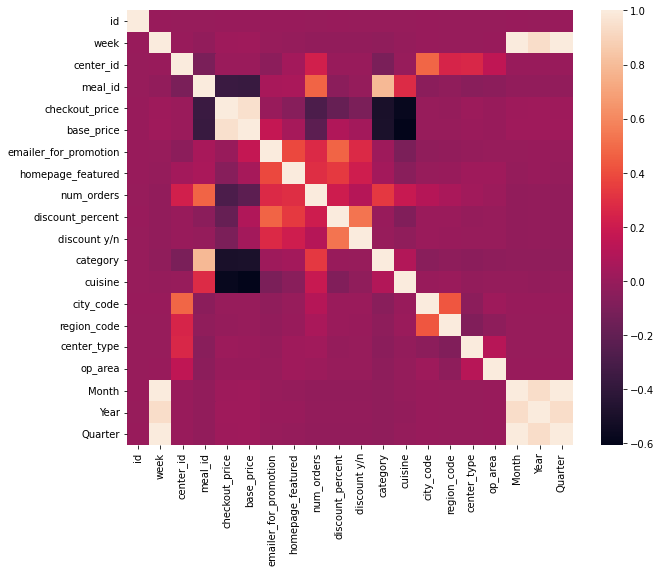

In [291]:
plt.figure(figsize=(10,8))
sns.heatmap(df_final.corr())

## C. BUILD MODEL

In [292]:
def root_mean_squared_log_error(y_true, y_pred):
  min_pred = min(y_pred[y_pred>0])
  y_pred[y_pred<0] = min_pred
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [293]:
train = df_final[df_final['week'].isin(range(1,130))]
test_set = df_final[df_final['week'].isin(range(130,146))]
X_train = train.drop('num_orders', axis=1)
X_test = test_set.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test_set['num_orders']

In [294]:
X_total = df_final.drop('num_orders', axis=1)
y_total = df_final['num_orders']

In [295]:
X_train_drop = X_train.drop(['week','id'], axis=1)
X_test_drop = X_test.drop(['week','id'], axis=1)
X_total_drop = X_total.drop(['week','id'], axis=1)

In [296]:
y_train_log_transform = np.log1p(y_train)
y_test_log_transform = np.log1p(y_test)
y_total_log_transform = np.log1p(y_total)

In [297]:
df_final.corr()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount_percent,discount y/n,category,cuisine,city_code,region_code,center_type,op_area,Month,Year,Quarter
id,1.000000,0.002225,-0.000403,-0.001303,0.001941,0.002909,0.002001,0.003111,0.000702,0.002910,0.001773,-0.000827,-0.001250,0.002737,0.000232,-0.000473,-0.000195,0.002220,0.001454,0.002130
week,0.002225,1.000000,0.005905,-0.020662,0.026581,0.028614,-0.000841,-0.008263,-0.017210,-0.017437,-0.017744,-0.026238,-0.008359,0.002979,-0.003190,-0.000049,0.002257,0.999640,0.940404,0.995927
center_id,-0.000403,0.005905,1.000000,-0.106699,0.012438,0.012048,-0.037194,0.041993,0.225584,0.005560,0.005237,-0.107388,-0.004182,0.482053,0.252361,0.260791,0.148410,0.005904,0.005100,0.005871
meal_id,-0.001303,-0.020662,-0.106699,1.000000,-0.360247,-0.365208,0.061692,0.070441,0.476058,-0.043672,-0.009682,0.788383,0.279578,-0.047697,-0.027083,-0.050557,-0.038960,-0.020680,-0.022723,-0.020992
checkout_price,0.001941,0.026581,0.012438,-0.360247,1.000000,0.953389,0.004818,-0.057184,-0.282108,-0.185213,-0.103340,-0.494660,-0.574149,-0.003720,-0.005415,0.015923,0.007062,0.026652,0.027494,0.026615
base_price,0.002909,0.028614,0.012048,-0.365208,0.953389,1.000000,0.171173,0.057156,-0.222306,0.090994,0.043064,-0.493697,-0.607112,-0.001691,-0.003867,0.013596,0.005894,0.028598,0.029464,0.028580
emailer_for_promotion,0.002001,-0.000841,-0.037194,0.061692,0.004818,0.171173,1.000000,0.390534,0.277147,0.477564,0.276454,0.025436,-0.099813,-0.028912,-0.017072,-0.006194,-0.003181,-0.000605,0.004931,-0.001216
homepage_featured,0.003111,-0.008263,0.041993,0.070441,-0.057184,0.057156,0.390534,1.000000,0.294490,0.338011,0.213979,0.044645,-0.050463,-0.001370,0.007142,0.030041,0.032506,-0.008308,0.006089,-0.007722
num_orders,0.000702,-0.017210,0.225584,0.476058,-0.282108,-0.222306,0.277147,0.294490,1.000000,0.205188,0.111766,0.330068,0.177768,0.112445,0.067001,0.038199,0.018651,-0.017024,-0.013514,-0.017029
discount_percent,0.002910,-0.017437,0.005560,-0.043672,-0.185213,0.090994,0.477564,0.338011,0.205188,1.000000,0.531243,0.006040,-0.084970,0.011625,0.009085,-0.005679,-0.004185,-0.017539,-0.015799,-0.017332


## Random forest regressor

In [218]:
rdf = RandomForestRegressor(n_estimators=200, max_depth=15, max_features=17)

In [220]:
rdf.fit(X_total_drop, y_total_log_transform)

RandomForestRegressor(max_depth=15, max_features=17, n_estimators=200)

In [221]:
prediction_rdf = rdf.predict(X_test_drop)

In [222]:
root_mean_squared_log_error(y_test_log_transform, prediction_rdf)

0.08481545637981451

## XGBoost Regressor

In [227]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.5,
                          max_depth=9, alpha=5, n_estimators=100)

In [228]:
xg_reg.fit(X_total_drop, y_total_log_transform)

XGBRegressor(alpha=5, colsample_bytree=0.8, learning_rate=0.5, max_depth=9,
             objective='reg:squarederror')

In [229]:
prediction_xgb = xg_reg.predict(X_test_drop)

In [230]:
root_mean_squared_log_error(y_test_log_transform, prediction_xgb)

0.07913746700386513

## Cat Boot Regressor

In [298]:
catbst = CatBoostRegressor(learning_rate=0.1,loss_function='RMSE',max_depth=9,verbose=False,)

In [299]:
catbst.fit(X_total_drop, y_total_log_transform)

In [26]:
catbst.fit(X_train_drop, y_train_log_transform)

In [300]:
prediction_cat = catbst.predict(X_test_drop)

In [301]:
root_mean_squared_log_error(y_test_log_transform, prediction_cat)

0.08559185670633603

0.08578689619244405

## E. TRANSFORM THE TEST DATASET

In [302]:
test_merge_meal = test.merge(meal_info, how='left', left_on='meal_id', right_on='meal_id')

In [303]:
test_merge_center = test_merge_meal.merge(fulfillment_center, how='left', left_on='center_id', right_on='center_id')

In [261]:
# city_encode = {590:4, 526:3, 638:2}
# test_merge_center['city_code'] = test_merge_center['city_code'].map(city_encode)
# test_merge_center['city_code'] = test_merge_center['city_code'].fillna(1)

In [304]:
columns_encoder = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']

for col, transform in zip(columns_encoder, transform_list):
  test_merge_center[col] = test_merge_center[col].map(transform)

In [305]:
test_final = test_merge_center.copy(deep=True)

In [306]:
test_final['Month'] = test_final['week'].apply(lambda x: int(x / 4)+1)
test_final['Year'] = test_final['week'].apply(lambda x: int(x / 52))
test_final['Quarter'] = test_final['week'].apply(lambda x: int(x / 13))

In [210]:
# test_final['Month'] = test_final['Month'].apply(lambda x: convert_month(x))
# test_final['Quarter'] = test_final['Quarter'].apply(lambda x: convert_quarter(x))

In [307]:
test_final_drop = test_final.drop(['week','id'], axis=1)

In [308]:
test_final_drop.head(3)

,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,discount_percent,discount y/n,category,cuisine,city_code,region_code,center_type,op_area,Month,Year,Quarter
0,9.0,50.0,158.11,159.11,0,0,0.628496,1,14.0,3.0,46.0,8.0,1.0,6.0,37,2,11
1,9.0,48.0,160.11,159.11,0,0,-0.628496,0,14.0,3.0,46.0,8.0,1.0,6.0,37,2,11
2,9.0,36.0,157.14,159.14,0,0,1.256755,1,14.0,3.0,46.0,8.0,1.0,6.0,37,2,11


## Random Forest Regressor

In [223]:
prediction_rdf = rdf.predict(test_final_drop)

In [224]:
prediction_rdf_transform = np.expm1(prediction_rdf).astype('int64')

In [225]:
submission = pd.DataFrame({'id':test['id'],
                           'num_orders':prediction_rdf_transform})

In [226]:
submission.to_csv('rdf_submission.csv', index=False)

## Catboost

In [309]:
prediction_cat = catbst.predict(test_final_drop)

In [310]:
prediction_cat_transform = np.expm1(prediction_cat).astype('int64')

In [311]:
submission = pd.DataFrame({'id':test['id'],
                           'num_orders':prediction_cat_transform})

In [312]:
submission.to_csv('cat_submission.csv', index=False)

## XGBOOST

In [231]:
prediction_xgb = xg_reg.predict(test_final_drop)

In [232]:
prediction_xgb_transform = np.expm1(prediction_xgb).astype('int64')

In [233]:
submission = pd.DataFrame({'id':test['id'],
                           'num_orders':prediction_xgb_transform})

In [234]:
submission.to_csv('xgb_submission.csv', index=False)